Generate final manuscript figures.

In [1]:
%load_ext autoreload
%autoreload 2

import os

import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import wandb

from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

from fme_diags.bias import (
    compute_time_mean_bias, plot_time_mean_bias,
    plot_time_mean_bias_list
)
from fme_diags.histogram import compute_histograms, plot_time_mean_histogram
from fme_diags.tropics.tropics import (
    compute_wavenumber_frequency_spectra, 
    plot_wavenumber_frequency_spectra
)
from fme_diags.utils import load_config, open_autoregressive_inference, open_baseline

_ = xr.set_options(keep_attrs=True)

## Define constants and make output plots directory

In [2]:
CONFIG_PATH = "./preds.yaml"
CONFIG_KEY = "topo-lr3.00e-04"
BASELINE_KEY = "baseline"
PREDS_START_DATE = "0031-01-01"
CHUNKS = {"timestep": 178}
FLIP_LAT = False

if FLIP_LAT:
    LAT_BOUNDS = (-15, 15)
else:
    LAT_BOUNDS = (15, -15)
    
PRECIP_FACTOR = 86400 
PRECIP_UNITS = "mm/day"
FLUX_UNITS = "W/m$^2$"

OUTDIR = "./figs"

In [3]:
os.makedirs(OUTDIR, exist_ok=True)

## Open prediction/target and reference datasets

In [4]:
config = load_config(CONFIG_PATH)

In [5]:
ds = open_autoregressive_inference(
    config[CONFIG_KEY]["url"], 
    start=PREDS_START_DATE, 
    flip_lat=FLIP_LAT, 
    chunks=CHUNKS
)
ds

,Array,Chunk
Bytes,7.05 GiB,88.00 MiB
Shape,"(2, 1, 14597, 180, 360)","(2, 1, 178, 180, 360)"
Count,167 Tasks,83 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.05 GiB,88.00 MiB
Shape,"(2, 1, 14597, 180, 360)","(2, 1, 178, 180, 360)"
Count,167 Tasks,83 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
ref_ds = open_baseline(
    config[BASELINE_KEY]["url"], 
    start=PREDS_START_DATE, 
    lat_coords=ds["lat"]
)
ref_ds

,Array,Chunk
Bytes,3.52 GiB,1.19 MiB
Shape,"(14600, 180, 360)","(124, 7, 360)"
Count,3480 Tasks,3120 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.52 GiB,1.19 MiB
Shape,"(14600, 180, 360)","(124, 7, 360)"
Count,3480 Tasks,3120 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Figure 1

In [7]:
da_precip = ds["surface_precipitation_rate"]

with ProgressBar():
    da_precip = da_precip.resample(time="1D").mean("time").compute() * PRECIP_FACTOR
    
da_precip.assign_attrs(units=PRECIP_UNITS)

hist_range = da_precip.min().compute().item(), da_precip.max().compute().item()

[########################################] | 100% Completed | 34.9s


In [8]:
%%time

precip_hist_ds = compute_histograms(da_precip, n_bins=300, hist_range=hist_range, lat_weighted=False)

CPU times: user 45.1 s, sys: 38.5 ms, total: 45.2 s
Wall time: 45.2 s


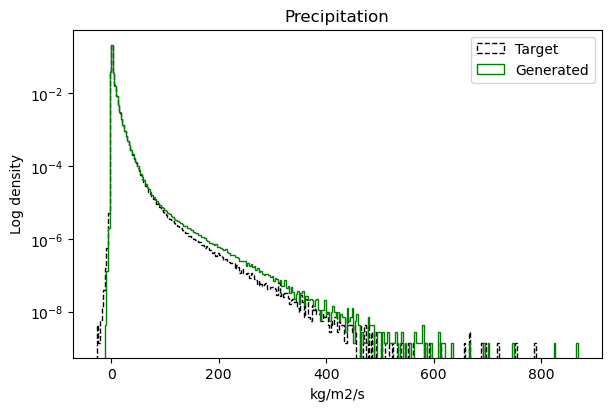

In [9]:
fig, ax = plot_time_mean_histogram(precip_hist_ds, figsize=(6, 4), log=True, density=True, histtype="step")
ax.set_title("Precipitation")
ax.set_xlabel(da_precip.units)
ax.set_ylabel("Log density")
plt.legend()
fig.show()

In [10]:
fig.savefig(os.path.join(OUTDIR, "precip_density.pdf"), bbox_inches="tight")

## Figure 2

In [11]:
%%time

da_wk = da_precip.isel(sample=0)
spectra = compute_wavenumber_frequency_spectra(
    da_wk, 
    segment_size=128, 
    latitude_bounds=LAT_BOUNDS
)
spectra

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3650, 'lat': 30, 'lon': 360})
INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0031-05-17 00:00:00 ... 0040-11-16 00:00:00
  * lat         (lat) float32 14.46 13.46 12.47 11.47 ... -12.47 -13.46 -14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0031-05-17 00:00:00 ... 0040-11-16 00:00:00
  * lat         (lat) float32 14.46 13.46 12.47 11.47 ... -12.47 -13.46 -14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).

Metadata for spectral power components is:
('component', 'wavenumber', 'frequency')
Coordinates:
  * wavenumber  (wavenumber) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
  * frequency   (frequency) float64 -0.5 -0.4922 -0.4844 ... 0.4844 0.4922 0.5
  * component   (component) <U13 'total' 'symmetric' 'antisymmetric'
{}

From smoothFrq121:  Frequency smoothing 1 times for subset of wavenumbers (pos frqs only)

Smoothing background spectrum in wavenumber (pos frq only)...
  Wavenumber smoothing 5 times for freq: 0.0078125
  Wavenumber smoothing 5 times for freq: 0.015625
  Wavenumber smoothing 5 times for freq: 0.0234375
  Wavenumber smoothing 5 times for freq: 0.03125
  Wavenumber smoothing 5 times for freq: 0.0390625
  Wavenumber smoothing 5 times for freq: 0.046875
  Wavenumber smoothing 5 times for freq: 0.0546875
  Wavenumber smoothing 5 times for freq: 0.0625
  Wavenumber smoothing 5 times for freq: 0.0703125
  Wavenumber smoothing 5 

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3650, 'lat': 30, 'lon': 360})


Frequency smoothing 10 times for all wavenumbers (pos frqs only)


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0031-05-17 00:00:00 ... 0040-11-16 00:00:00
  * lat         (lat) float32 14.46 13.46 12.47 11.47 ... -12.47 -13.46 -14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0031-05-17 00:00:00 ... 0040-11-16 00:00:00
  * lat         (lat) float32 14.46 13.46 12.47 11.47 ... -12.47 -13.46 -14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).

Metadata for spectral power components is:
('component', 'wavenumber', 'frequency')
Coordinates:
  * wavenumber  (wavenumber) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
  * frequency   (frequency) float64 -0.5 -0.4922 -0.4844 ... 0.4844 0.4922 0.5
  * component   (component) <U13 'total' 'symmetric' 'antisymmetric'
{}

From smoothFrq121:  Frequency smoothing 1 times for subset of wavenumbers (pos frqs only)

Smoothing background spectrum in wavenumber (pos frq only)...
  Wavenumber smoothing 5 times for freq: 0.0078125
  Wavenumber smoothing 5 times for freq: 0.015625
  Wavenumber smoothing 5 times for freq: 0.0234375
  Wavenumber smoothing 5 times for freq: 0.03125
  Wavenumber smoothing 5 times for freq: 0.0390625
  Wavenumber smoothing 5 times for freq: 0.046875
  Wavenumber smoothing 5 times for freq: 0.0546875
  Wavenumber smoothing 5 times for freq: 0.0625
  Wavenumber smoothing 5 times for freq: 0.0703125
  Wavenumber smoothing 5 

<xarray.Dataset>
Dimensions:     (wavenumber: 361, frequency: 129, component: 4, source: 2)
Coordinates:
  * wavenumber  (wavenumber) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
  * frequency   (frequency) float64 -0.5 -0.4922 -0.4844 ... 0.4844 0.4922 0.5
  * component   (component) <U13 'total' 'symmetric' ... 'background'
  * source      (source) <U10 'target' 'prediction'
Data variables:
    spectrum    (source, component, wavenumber, frequency) float64 0.0 ... 9....

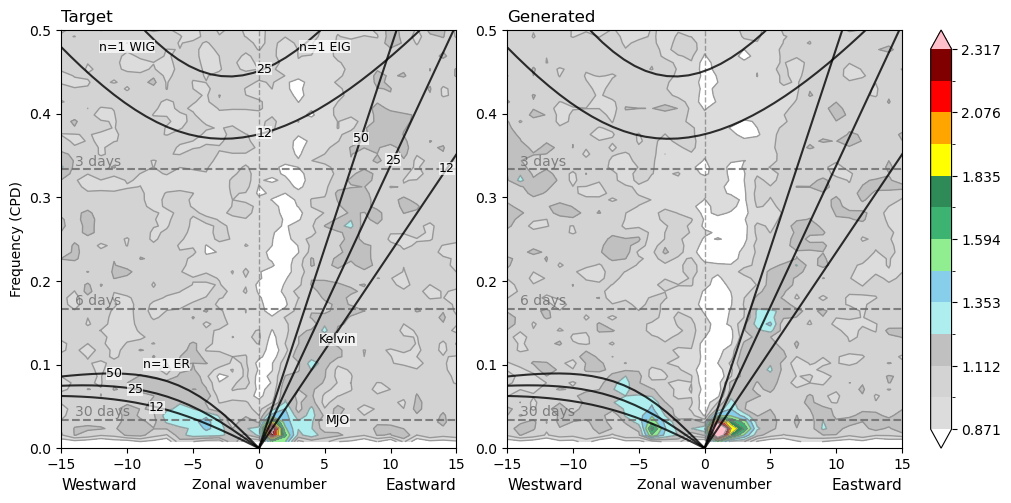

In [12]:
fig, axs = plot_wavenumber_frequency_spectra(
    spectra, 
    component="symmetric",
    figsize=(10, 5),
    plot_error=False,
)
fig.suptitle("")
fig.show()

In [13]:
fig.savefig(os.path.join(OUTDIR, "wk.pdf"), bbox_inches="tight")

## Figure 3

In [14]:
time_mean_bias = compute_time_mean_bias(
    da_precip.sel(source="prediction"),
    da_precip.sel(source="target")
)

In [15]:
ref_da_precip = ref_ds["surface_precipitation_rate"]

with ProgressBar():
    ref_da_precip = ref_da_precip.resample(time="1D").mean("time").compute() * PRECIP_FACTOR

ref_da_precip.assign_attrs(units=PRECIP_UNITS)

ref_time_mean_bias = compute_time_mean_bias(
    ref_da_precip,
    da_precip.sel(source="target"),
)

[########################################] | 100% Completed |  1min 25.2s


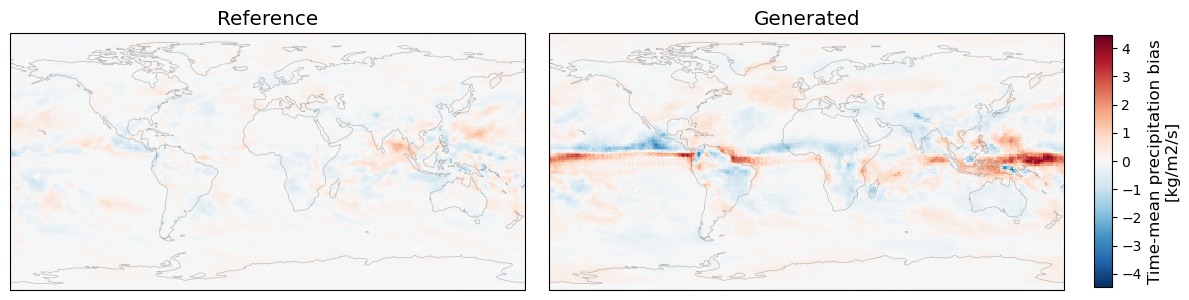

In [16]:
fig, axs = plot_time_mean_bias(
    time_mean_bias, 
    ref_time_mean_bias,
    var_name="precipitation",
    figsize=(12, 3),
)
fig.show()

In [17]:
fig.savefig(os.path.join(OUTDIR, "precip_bias.pdf"), bbox_inches="tight")

## Figure 4

In [18]:
da_OLR = ds["FLUT"].assign_attrs(units=FLUX_UNITS)

time_mean_bias_OLR = compute_time_mean_bias(
    da_OLR.sel(source="prediction"),
    da_OLR.sel(source="target")
)

[########################################] | 100% Completed | 24.8s


In [19]:
ref_da_OLR = ref_ds["FLUT"].assign_attrs(units=FLUX_UNITS)
ref_time_mean_bias_OLR = compute_time_mean_bias(
    ref_da_OLR,
    da_OLR.sel(source="target")
)

[########################################] | 100% Completed | 18.9s


In [20]:
da_OSR = ds["top_of_atmos_upward_shortwave_flux"].assign_attrs(units=FLUX_UNITS)
time_mean_bias_OSR = compute_time_mean_bias(
    da_OSR.sel(source="prediction"),
    da_OSR.sel(source="target")
)

[########################################] | 100% Completed | 30.2s


In [21]:
ref_da_OSR = ref_ds["top_of_atmos_upward_shortwave_flux"].assign_attrs(units=FLUX_UNITS)
ref_time_mean_bias_OSR = compute_time_mean_bias(
    ref_da_OSR,
    da_OSR.sel(source="target")
)

[########################################] | 100% Completed |  1min  9.2s


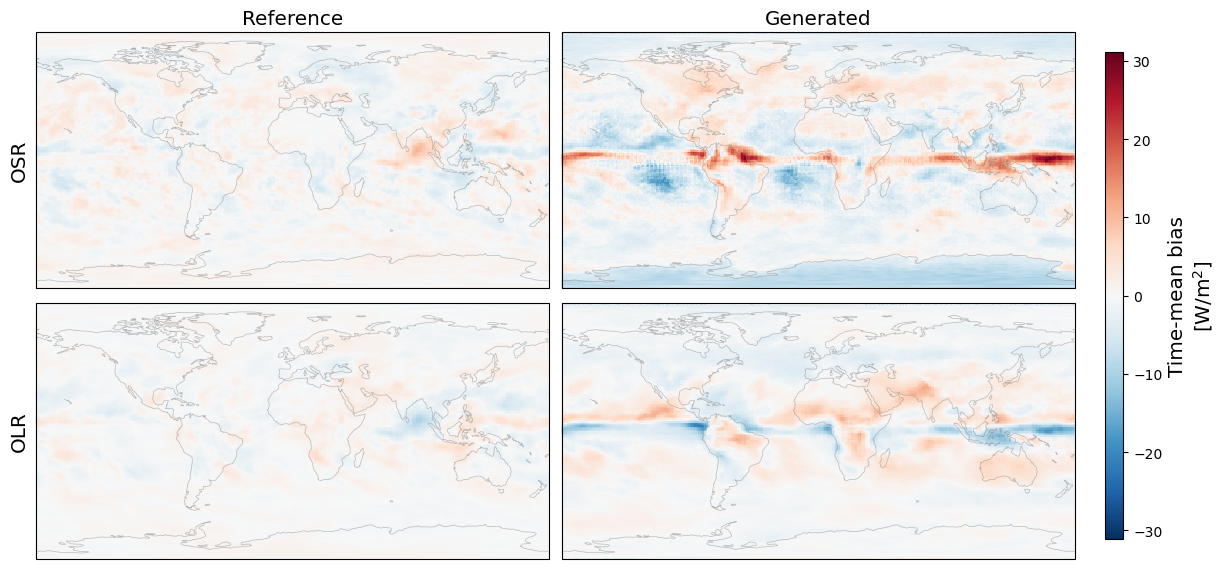

In [22]:
fig, axs = plot_time_mean_bias_list(
    [time_mean_bias_OSR, time_mean_bias_OLR], 
    [ref_time_mean_bias_OSR, ref_time_mean_bias_OLR],
    var_names=["OSR", "OLR"],
    figsize=(12, 5.8),
)
fig.show()

In [23]:
fig.savefig(os.path.join(OUTDIR, "osr_olr_bias.pdf"), bbox_inches="tight")

## Figure 3 (alternative combined version of Fig 3 + 4)

In [24]:
time_mean_bias = time_mean_bias.assign_attrs(units=PRECIP_UNITS)
ref_time_mean_bias = ref_time_mean_bias.assign_attrs(units=PRECIP_UNITS)
time_mean_bias_OSR = time_mean_bias_OSR.assign_attrs(units=FLUX_UNITS)
ref_time_mean_bias_OSR = ref_time_mean_bias_OSR.assign_attrs(units=FLUX_UNITS)
time_mean_bias_OLR = time_mean_bias_OLR.assign_attrs(units=FLUX_UNITS)
ref_time_mean_bias_OLR = ref_time_mean_bias_OLR.assign_attrs(units=FLUX_UNITS)

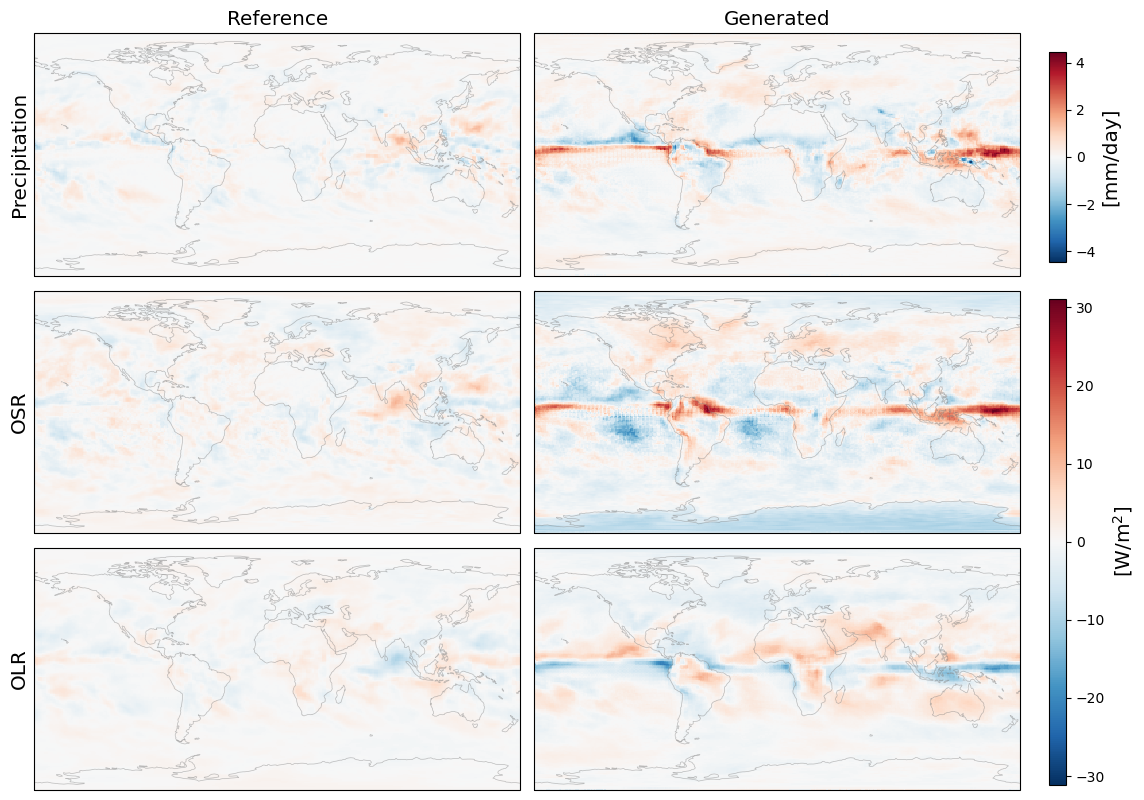

In [25]:
fig, axs = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(11.5, 8.1),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

im_precip = plot_time_mean_bias_list(
    [time_mean_bias],
    [ref_time_mean_bias],
    var_names=["Precipitation"],
    axs=axs[0:1]
)

im_fluxes = plot_time_mean_bias_list(
    [time_mean_bias_OSR, time_mean_bias_OLR], 
    [ref_time_mean_bias_OSR, ref_time_mean_bias_OLR],
    var_names=["OSR", "OLR"],
    axs=axs[1:]
)

axs[1][0].set_title("")
axs[1][1].set_title("")

plt.tight_layout()
fig.subplots_adjust(right=0.9)

cbar_ax = fig.add_axes([0.91, 0.67, 0.015, 0.26])
cbar = fig.colorbar(
    im_precip,
    cax=cbar_ax,
    orientation="vertical",
)
cbar.set_label(
    f"[{time_mean_bias.units}]", fontsize="x-large"
)

cbar_ax = fig.add_axes([0.91, 0.025, 0.015, 0.6])
cbar = fig.colorbar(
    im_fluxes,
    cax=cbar_ax,
    orientation="vertical",
)
cbar.set_label(
    f"[{time_mean_bias_OSR.units}]", fontsize="x-large"
)

fig.show()

In [26]:
fig.savefig(os.path.join(OUTDIR, "bias_maps.pdf"), bbox_inches="tight")